In [ ]:
!pip install -q git+https://github.com/RobertJaro/NF2.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 31.5 MB/s eta 0:00:00


In [ ]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data

# visualization
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
request.urlretrieve('http://kanzelhohe.uni-graz.at/nf2/example_7115.nf2', 'example_7115.nf2')

('example_7115.nf2', <http.client.HTTPMessage at 0x7f7e204b7280>)

In [ ]:
nf2_path = 'example_7115.nf2'

In [ ]:
state = torch.load(nf2_path, map_location=device)
state

{'model': BModel(
   (d_in): Linear(in_features=3, out_features=256, bias=True)
   (linear_layers): ModuleList(
     (0): Linear(in_features=256, out_features=256, bias=True)
     (1): Linear(in_features=256, out_features=256, bias=True)
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): Linear(in_features=256, out_features=256, bias=True)
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): Linear(in_features=256, out_features=256, bias=True)
   )
   (d_out): Linear(in_features=256, out_features=3, bias=True)
   (activation): Sine()
 ),
 'cube_shape': [344, 224, 160],
 'b_norm': 2500,
 'spatial_norm': 160,
 'meta_info': MetaDict([('simple', True),
           ('bitpix', 32),
           ('naxis', 2),
           ('naxis1', 688),
           ('naxis2', 448),
           ('pcount', 0),
           ('gcount', 1),
           ('xt

In [ ]:
meta_info = state['meta_info']
print(meta_info['date-obs'])
print(meta_info['drms_id'])

2017-09-06T08:34:42.100
hmi.sharp_cea_720s:6012232:Br


In [ ]:
jsoc_email = 'mgjeon@khu.ac.kr'
client = drms.Client(email=jsoc_email, verbose=True)

In [ ]:
noaa_nums = [12673]
date = datetime(2017, 9, 6, 8, 34, 42)
print(date.isoformat('_', timespec='seconds'))
print(client.query('hmi.Mharp_720s[][%sZ]' % date.isoformat('_', timespec='seconds'),
                              key=['NOAA_AR', 'HARPNUM']))
harpnum = find_HARP(date, noaa_nums, client)
print(harpnum)

download_dir = 'NOAA' + str(noaa_nums[0])
print(download_dir)
os.makedirs(download_dir, exist_ok=True)

ds = 'hmi.sharp_cea_720s[%d][%s]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}' % \
     (harpnum, date.isoformat('_', timespec='seconds'))
print(ds)

donwload_ds(ds, download_dir, client)

2017-09-06_08:34:42
   NOAA_AR  HARPNUM
0    12673     7115
1    12674     7117
2        0     7118
3    12677     7122
4    12675     7123
5        0     7125
6    12678     7127
7        0     7128
8        0     7129
7115
NOAA12673
hmi.sharp_cea_720s[7115][2017-09-06_08:34:42]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}
Export request pending. [id=JSOC_20230203_187, status=2]
Waiting for 5 seconds...
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bp.fits
  -> NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bp.fits
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bt.fits
  -> NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bt.fits
    record: hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI]
  filename: hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits
  -> NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits
    record: hmi.sharp_

,record,url,download
0,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...
1,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...
2,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...
3,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...
4,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...
5,hmi.sharp_cea_720s[7115][2017.09.06_08:36:00_TAI],http://jsoc.stanford.edu/SUM66/D1606162400/S00...,/content/NOAA12673/hmi.sharp_cea_720s.7115.201...


In [ ]:
from sunpy.map import Map

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


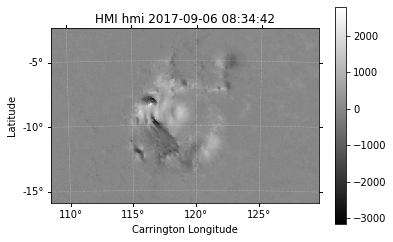

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


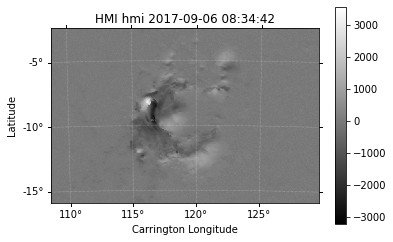

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


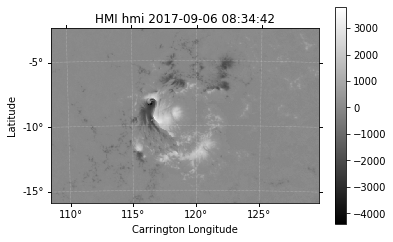

In [ ]:
hmi_p = '/content/NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bp.fits'
Map(hmi_p).peek()

hmi_t = '/content/NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Bt.fits'
Map(hmi_t).peek()

hmi_r = '/content/NOAA12673/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits'
Map(hmi_r).peek()

In [ ]:
Map(hmi_p).data.shape

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


(448, 688)

In [ ]:
b = load_cube(nf2_path, device, progress=True, strides=1)

  2%|▏         | 231/12329 [00:05<04:55, 40.93it/s]


KeyboardInterrupt: ignored

In [ ]:
npy_path = nf2_path.replace('.nf2', '.npy')
np.save(npy_path, b)

In [ ]:
!pip install -q mayavi PyQt5

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.2/229.2 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 17.1 MB/s eta 0:00:00


In [ ]:
from nf2.evaluation.vtk import save_vtk

In [ ]:
vtk_path = nf2_path.replace('.nf2', '.vtk')
save_vtk(b, vtk_path, 'B')

In [ ]:
print(type(b))
print(b.shape)

bx = b[:, :, :, 0]
by = b[:, :, :, 1]
bz = b[:, :, :, 2]

#bstack = np.stack([bx, by, bz], axis=-1)
#np.array_equal(bstack[..., 0], bx)

<class 'numpy.ndarray'>
(344, 224, 160, 3)


(224, 344)


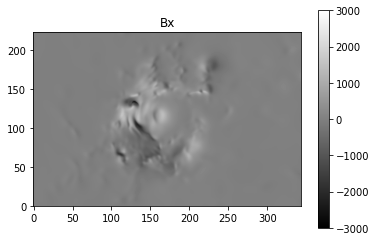

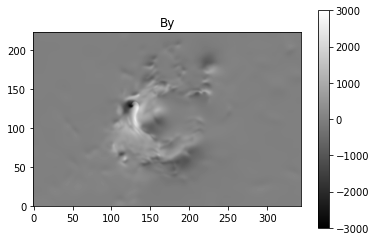

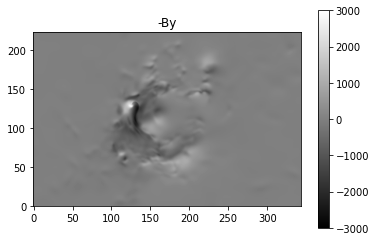

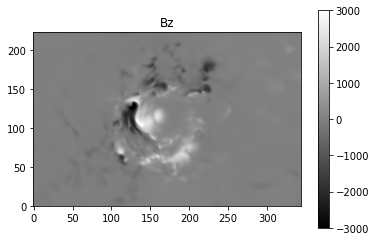

In [ ]:
#z=0
fig, ax = plt.subplots()
bx_z0 = bx[:, :, 0]
print(bx_z0.transpose().shape)
im = ax.imshow(bx_z0.transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('Bx')
plt.colorbar(im)
plt.savefig('Bx.png', dpi=300)

fig, ax = plt.subplots()
by_z0 = by[:, :, 0]
im = ax.imshow(by_z0.transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('By')
plt.colorbar(im)
plt.savefig('By.png', dpi=300)

fig, ax = plt.subplots()
by_z0 = -by[:, :, 0]
im = ax.imshow(by_z0.transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('-By')
plt.colorbar(im)
plt.savefig('By_m.png', dpi=300)

fig, ax = plt.subplots()
bz_z0 = bz[:, :, 0]
im = ax.imshow(bz_z0.transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('Bz')
plt.colorbar(im)
plt.savefig('Bz.png', dpi=300)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


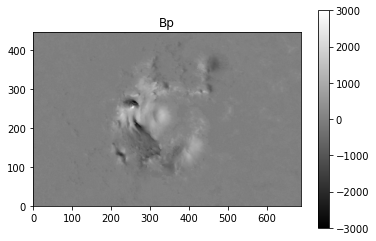

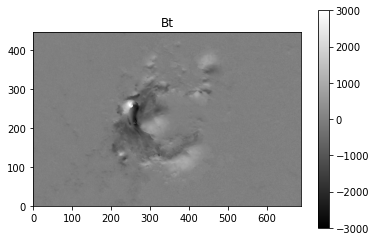

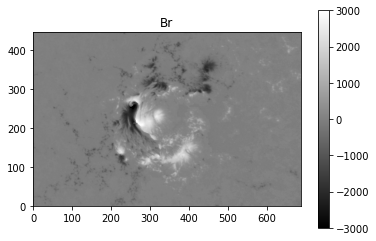

In [ ]:
#z=0
fig, ax = plt.subplots()
im = ax.imshow(Map(hmi_p).data, origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('Bp')
plt.colorbar(im)
plt.savefig('Bp.png', dpi=300)

fig, ax = plt.subplots()
im = ax.imshow(Map(hmi_t).data, origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('Bt')
plt.colorbar(im)
plt.savefig('Bt.png', dpi=300)

fig, ax = plt.subplots()
bz_z0 = bz[:, :, 0]
im = ax.imshow(Map(hmi_r).data, origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_title('Br')
plt.colorbar(im)
plt.savefig('Br.png', dpi=300)

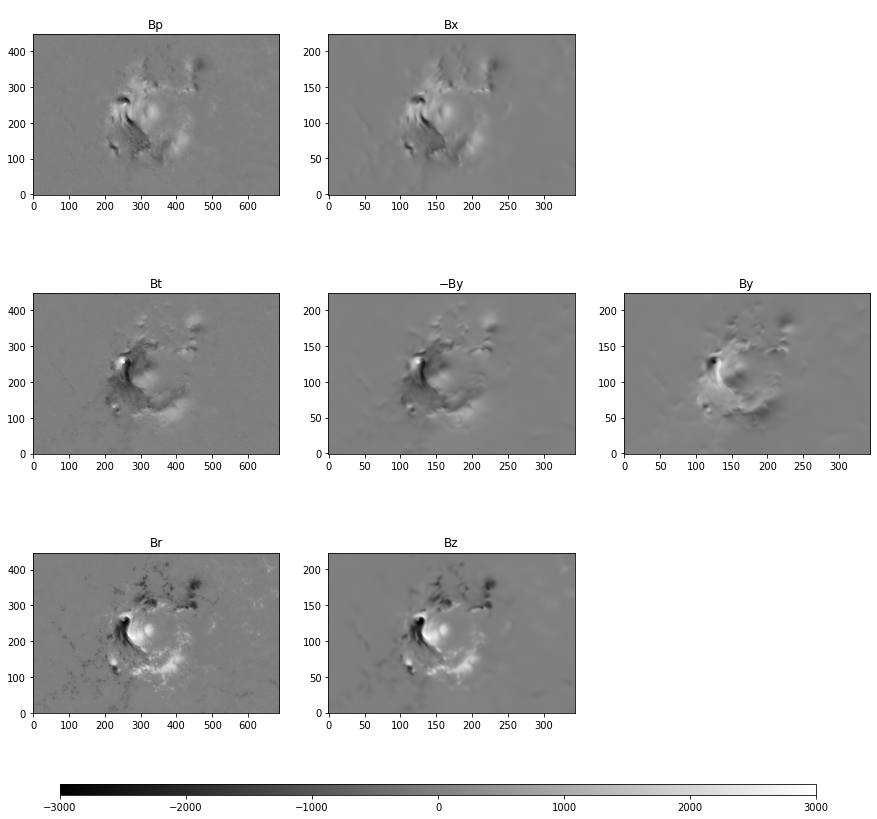

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes
#z=0
bx_z0 = bx[:, :, 0].transpose()
by_z0 = by[:, :, 0].transpose()
by_m_z0 = -by_z0
bz_z0 = bz[:, :, 0].transpose()

bp = Map(hmi_p).data
bt = Map(hmi_t).data
br = Map(hmi_r).data

vmax = 3000
vmin = -3000


fig, axes = plt.subplots(3,3, figsize=(15, 15))
im = axes[0,0].imshow(bp, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[0,0].set_title('Bp')
axes[1,0].imshow(bt, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[1,0].set_title('Bt')
axes[2,0].imshow(br, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[2,0].set_title('Br')

axes[0,1].imshow(bx_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[0,1].set_title('Bx')
axes[1,1].imshow(by_m_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[1,1].set_title('−By')
axes[2,1].imshow(bz_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[2,1].set_title('Bz')

axes[1,2].imshow(by_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[1,2].set_title('By')

axes[0,2].axis('off')
axes[2,2].axis('off')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

(344, 224, 160)


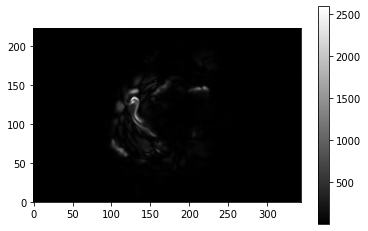

In [ ]:
j = curl(b)
norm_j = vector_norm(j)
print(norm_j.shape)
plt.imshow(norm_j[..., 0].transpose(), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

(344, 224, 160)


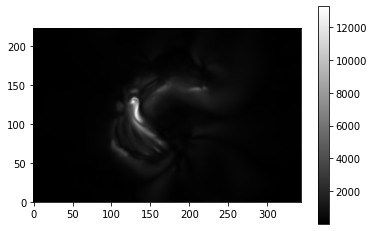

In [ ]:
j = curl(b)
norm_j = vector_norm(j)
print(norm_j.shape)
plt.imshow(norm_j.sum(-1).transpose(), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
Efree = get_free_mag_energy(b)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Potential Field:   0%|          | 22/12329 [01:13<11:23:36,  3.33s/it]


KeyboardInterrupt: ignored